
## Chapter 1: What Are Word and Sentence Embeddings?

**The Core Concept:**
Computers cannot process raw text. They require numbers. Embeddings are the method of translating text into a vector (a list of numbers) in a high-dimensional space.

**Why this matters for industry:**

* **Semantic Meaning:** Unlike simple "one-hot encoding" (which is just counting words), embeddings capture *meaning*. In vector space, the word "King" is mathematically closer to "Queen" than it is to "Car".
* **Dimensionality:** A word might be represented by a list of 768 or 1024 numbers (dimensions).
* **Current Standard:** We rarely train embeddings from scratch anymore. In the industry, we use pre-trained models like **BERT**, **RoBERTa**, or **OpenAI's text-embedding-3** (via API) to generate these vectors instantly.




/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Shape of embeddings: (6, 384)


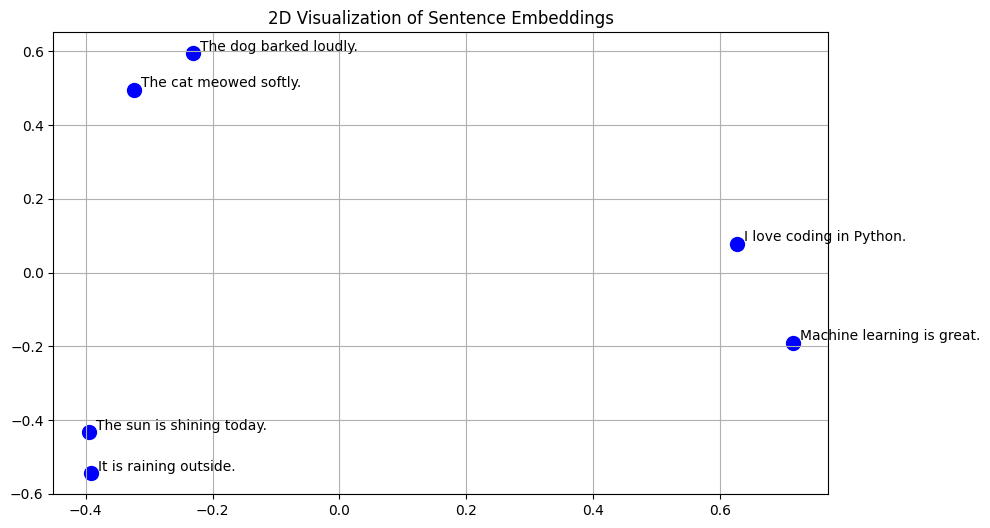

In [ ]:
# Install necessary library
!pip install sentence-transformers matplotlib scikit-learn

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

# 1. Load a pre-trained model (Industry Standard for sentence embeddings)
model = SentenceTransformer('all-MiniLM-L6-v2')

# 2. Define sentences - notice the semantic groupings
sentences = [
    "The dog barked loudly.",       # Animal/Sound
    "The cat meowed softly.",       # Animal/Sound
    "I love coding in Python.",     # Tech
    "Machine learning is great.",   # Tech
    "The sun is shining today.",    # Weather
    "It is raining outside."        # Weather
]

# 3. Generate Embeddings
embeddings = model.encode(sentences)
print(f"Shape of embeddings: {embeddings.shape}") # (6, 384) - 6 sentences, 384 dimensions

# 4. Reduce dimensions from 384 to 2 for visualization (using PCA)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# 5. Visualization
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=100, c='blue')

for i, sentence in enumerate(sentences):
    plt.annotate(sentence, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]),
                 xytext=(5, 2), textcoords='offset points')

plt.title("2D Visualization of Sentence Embeddings")
plt.grid(True)
plt.show()

## Chapter 2: What is Similarity Between Sentences?

**The Core Concept:**
Once text is converted into numbers (vectors), we need to measure how "close" they are to each other.

**Cosine Similarity:**
While you can measure the straight-line distance (Euclidean), **Cosine Similarity** is the industry standard for NLP. It measures the **cosine of the angle** between two vectors.

* **1.0:** Vectors point in the exact same direction (Identical meaning).
* **0.0:** Vectors are 90° apart (Unrelated).
* **-1.0:** Vectors point in opposite directions (Opposite meaning).

The formula is:

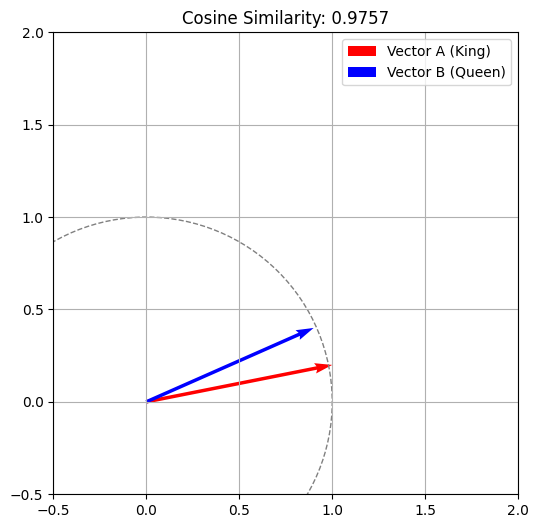

In [ ]:




import numpy as np
import matplotlib.pyplot as plt

def plot_vectors(v1, v2):
    """Plots two vectors and visualizes the angle between them."""

    # Calculate Cosine Similarity manually
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    cosine_sim = dot_product / (norm_v1 * norm_v2)

    # Setup plot
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-0.5, 2)
    ax.set_ylim(-0.5, 2)
    ax.grid(True)

    # Draw Vectors
    ax.quiver(0, 0, v1[0], v1[1], angles='xy', scale_units='xy', scale=1, color='r', label='Vector A (King)')
    ax.quiver(0, 0, v2[0], v2[1], angles='xy', scale_units='xy', scale=1, color='b', label='Vector B (Queen)')

    # Draw reference unit circle
    circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
    ax.add_artist(circle)

    plt.title(f"Cosine Similarity: {cosine_sim:.4f}")
    plt.legend()
    plt.show()

# Define two vectors (2D for easy visualization)
# Example: Almost similar vectors
vec_a = np.array([1, 0.2])
vec_b = np.array([0.9, 0.4])

plot_vectors(vec_a, vec_b)




---

## Chapter 3: What Is Attention in Language Models?

**The Core Concept:**
Before "Attention," models processed words strictly sequentially (left to right) and often forgot the beginning of a sentence by the time they reached the end.

**Self-Attention** allows the model to look at **all words in the sentence at the same time** and decide which words are relevant to the current word it is processing.

**The Mechanism (simplified):**
Every word gets three distinct representations (vectors):

1. **Query (Q):** What the word is looking for.
2. **Key (K):** What the word identifies as.
3. **Value (V):** The actual content of the word.

We calculate similarity between the **Query** of the current word and the **Keys** of all other words to create an **Attention Map** (heatmap).


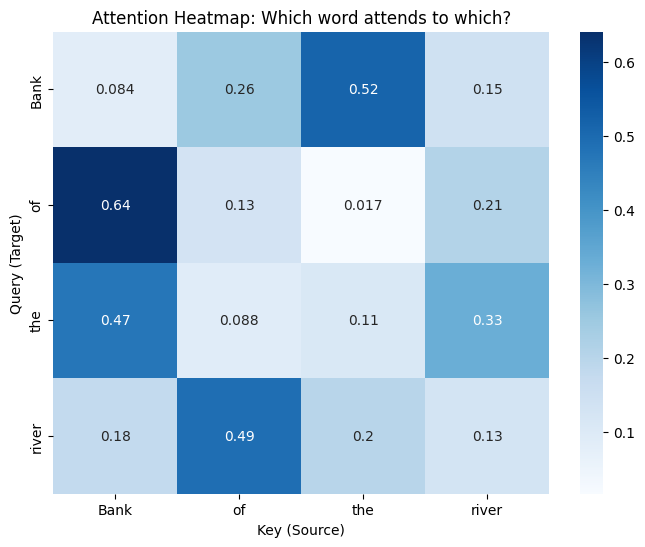

This heatmap shows how strongly each word focuses on every other word.


In [ ]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def scaled_dot_product_attention(query, key, value):
    d_k = query.size(-1)

    # 1. MatMul: Calculate scores (Q * K^T)
    # This determines how much focus to put on other parts of the input
    scores = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(d_k)

    # 2. Softmax: Normalize scores to probabilities (0 to 1)
    attention_weights = F.softmax(scores, dim=-1)

    # 3. MatMul: Apply weights to Values (Weights * V)
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

# --- Simulation ---

# Let's assume we have 4 words: "Bank", "of", "the", "river"
# We create fake embeddings (random numbers) for demonstration
seq_len = 4
d_model = 8 # Dimension of the vector

np.random.seed(42)
# Creating random Q, K, V matrices representing the sentence state
Q = torch.tensor(np.random.randn(1, seq_len, d_model), dtype=torch.float32)
K = torch.tensor(np.random.randn(1, seq_len, d_model), dtype=torch.float32)
V = torch.tensor(np.random.randn(1, seq_len, d_model), dtype=torch.float32)

# Run Attention
output, attn_weights = scaled_dot_product_attention(Q, K, V)

# --- Visualization ---
labels = ["Bank", "of", "the", "river"]

plt.figure(figsize=(8, 6))
sns.heatmap(attn_weights[0].numpy(), xticklabels=labels, yticklabels=labels, cmap="Blues", annot=True)
plt.title("Attention Heatmap: Which word attends to which?")
plt.xlabel("Key (Source)")
plt.ylabel("Query (Target)")
plt.show()

print("This heatmap shows how strongly each word focuses on every other word.")




## Chapter 4

What Are Transformer Models and How Do They Work?

https://www.nlpdemystified.org/course/transformers